# Final Presentation

Our final project is a text analysis and processing of Adam Smith's ["Wealth of Nations](https://en.wikipedia.org/wiki/The_Wealth_of_Nations)". This book, published in 1776, is considered a cornerstone of modern economic thought and one of the first works to explore the concept of free market capitalism. In our project, we'll  use natural language processing techniques to analyze and understand the key ideas and concepts presented in this influential work. By applying these techniques, we hope to gain a better understanding of the ideas and arguments presented in the "Wealth of Nations".
![wealth of nations](./images/won.jpeg)


In the first part of our analysis, we will use a **Negative Binomial** Model to investigate the relationship between the keywords "profit" and "wages" with a list of [positive words](https://ptrckprry.com/course/ssd/data/positive-words.txt).

In the second part of our analysis, we find the most important sentence using a Network Model and **PageRank** algorithm.

In the third part of our analysis, we divide the sentences into ten sections using **K-Medoids Clustering** algorithm. And find the topic sentence of each section.


## Library

In [1]:
## Install on Colab
# ! pip install pymc3, sklearn, scikit-learn-extra,sentence-transformers, typing-extensions, cython, networkx

In [2]:
# ! pip install scikit-learn-extra

In [3]:
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
import os
from collections import Counter, defaultdict

import networkx
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
%matplotlib inline
from sklearn.datasets import load_digits

/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Bayesian modeling

#### Utility functions

In [4]:
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, var_names=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,var_names=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, var_names=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')

def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = ''
    lower = texts.lower()
    no_punctuation = NON_ALPHANUM.sub(r' ', lower)
    no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
    return no_non_ascii

def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_words_paragraphs(paragraphs, words):
    word_para = defaultdict(list)
    for p in paragraphs:
        for w in words:
            word_para[w].append(p.count(w))
            
    return dict(word_para)

def get_any_words_paragraphs(paragraphs, words):
    word_para = []
    for p in tqdm(paragraphs):
        total = 0
        for w in words:
            total += p.count(w)
        word_para.append(total)
            
    return word_para

### Import txt files from google drive

In [72]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
file_path  = "/Users/muhenan/Desktop/Neu_Semester/freshman_first/Classes/INFO_6105_DS/W12L1/won"
text_paragraphs = []
text_sentences = []
for root, dirs, files in os.walk(file_path):
    for file in files:
        if file.endswith(".txt"):
            print(os.path.join(root, file))
            with open(os.path.join(root, file), "r") as input:
                text_original = input.read()
                sentences = text_original.replace('.\n','. ').split('. ')
                paragraphs = text_original.split("\n\n")   #\n\n denotes there is a blank line in between paragraphs.
            text_paragraphs.extend(paragraphs)
            text_sentences.extend(sentences)


print(f"Number of paragraphs = {len(text_paragraphs)}")
print(f"Number of sentences = {len(text_sentences)}")
print(text_paragraphs[0])
print(text_sentences[0])

/Users/muhenan/Desktop/Neu_Semester/freshman_first/Classes/INFO_6105_DS/W12L1/won/On Wages and Profit in the different Employments of Labour and Stock.txt
/Users/muhenan/Desktop/Neu_Semester/freshman_first/Classes/INFO_6105_DS/W12L1/won/On the Wages of Labour.txt
/Users/muhenan/Desktop/Neu_Semester/freshman_first/Classes/INFO_6105_DS/W12L1/won/On the Profits of Stock.txt
/Users/muhenan/Desktop/Neu_Semester/freshman_first/Classes/INFO_6105_DS/W12L1/won/On the Origin and Use of Money.txt
/Users/muhenan/Desktop/Neu_Semester/freshman_first/Classes/INFO_6105_DS/W12L1/won/On the Component Parts of the Price of Commodities.txt
/Users/muhenan/Desktop/Neu_Semester/freshman_first/Classes/INFO_6105_DS/W12L1/won/On the Natural and Market Price of Commodities.txt
/Users/muhenan/Desktop/Neu_Semester/freshman_first/Classes/INFO_6105_DS/W12L1/won/Chapter 1.txt
/Users/muhenan/Desktop/Neu_Semester/freshman_first/Classes/INFO_6105_DS/W12L1/won/That the Division of Labour is limited by the Extent of the M

In [7]:
df = pd.DataFrame(text_sentences, columns = ['Sentence'])
df.head()

Sentence
0  The whole of the advantages and disadvantages ...
1  If in the same neighbourhood, there was any em...
2  This at least would be the case in a society w...
3  Every man's interest would prompt him to seek ...
4  \nPecuniary wages and profit, indeed, are ever...

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1809 entries, 0 to 1808
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  1809 non-null   object
dtypes: object(1)
memory usage: 14.3+ KB


Text(0.5, 1.0, 'Distribution of number of words in each sentence')

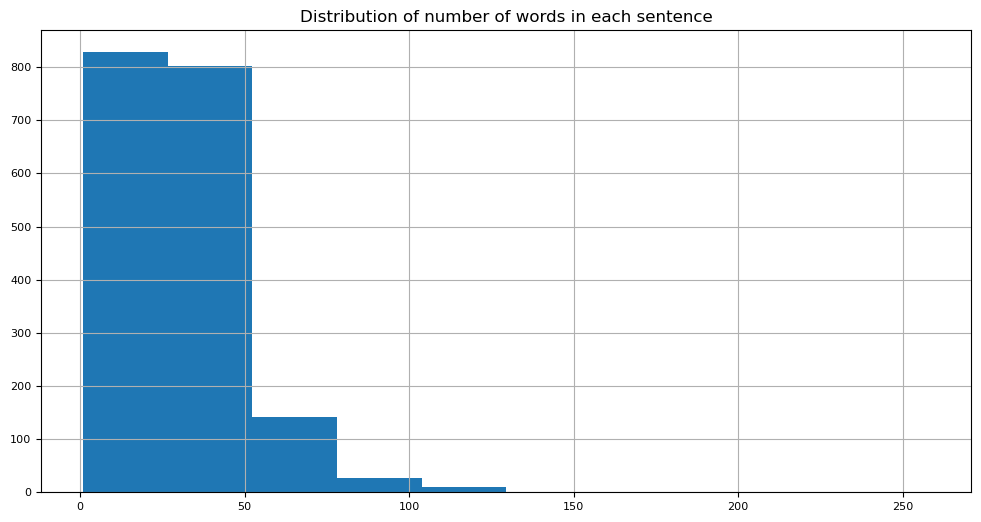

In [9]:
df['NumWords'] = df['Sentence'].apply(lambda x: len(x.split()))
df[['NumWords']].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distribution of number of words in each sentence")

In [10]:
all_words = ''.join([word for word in df['Sentence']]).replace('\n', ' ')
all_words[0:1000]

"The whole of the advantages and disadvantages of the different employments of labour and stock must, in the same neighbourhood, be either perfectly equal or continually tending to equalityIf in the same neighbourhood, there was any employment evidently either more or less advantageous than the rest, so many people would crowd into it in the one case, and so many would desert it in the other, that its advantages would soon return to the level of other employmentsThis at least would be the case in a society where things were left to follow their natural course, where there was perfect liberty, and where every man was perfectly free both to choose what occupation he thought proper, and to change it as often as he thought properEvery man's interest would prompt him to seek the advantageous, and to shun the disadvantageous employment Pecuniary wages and profit, indeed, are everywhere in Europe extremely different according to the different employments of labour and stockBut this difference

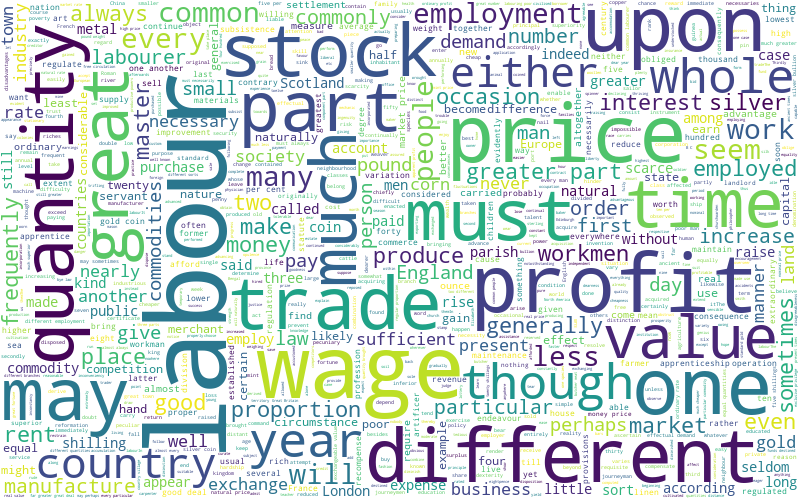

In [11]:
from wordcloud import WordCloud

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=500, 
                      max_font_size=110, 
                      background_color="white", 
                      max_words=3000, 
                      contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(all_words)

# Visualize the word cloud
wordcloud.to_image()

In [12]:
df['Sentence2'] = df['Sentence'].apply(normalize_texts)
df['Sentence2'] = df['Sentence2'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

df.head()

Sentence  NumWords  \
0  The whole of the advantages and disadvantages ...        29   
1  If in the same neighbourhood, there was any em...        50   
2  This at least would be the case in a society w...        49   
3  Every man's interest would prompt him to seek ...        16   
4  \nPecuniary wages and profit, indeed, are ever...        20   

                                           Sentence2  
0  the whole the advantages and disadvantages the...  
1  the same neighbourhood there was any employmen...  
2  this least would the case society where things...  
3  every man interest would prompt him seek the a...  
4  pecuniary wages and profit indeed are everywhe...

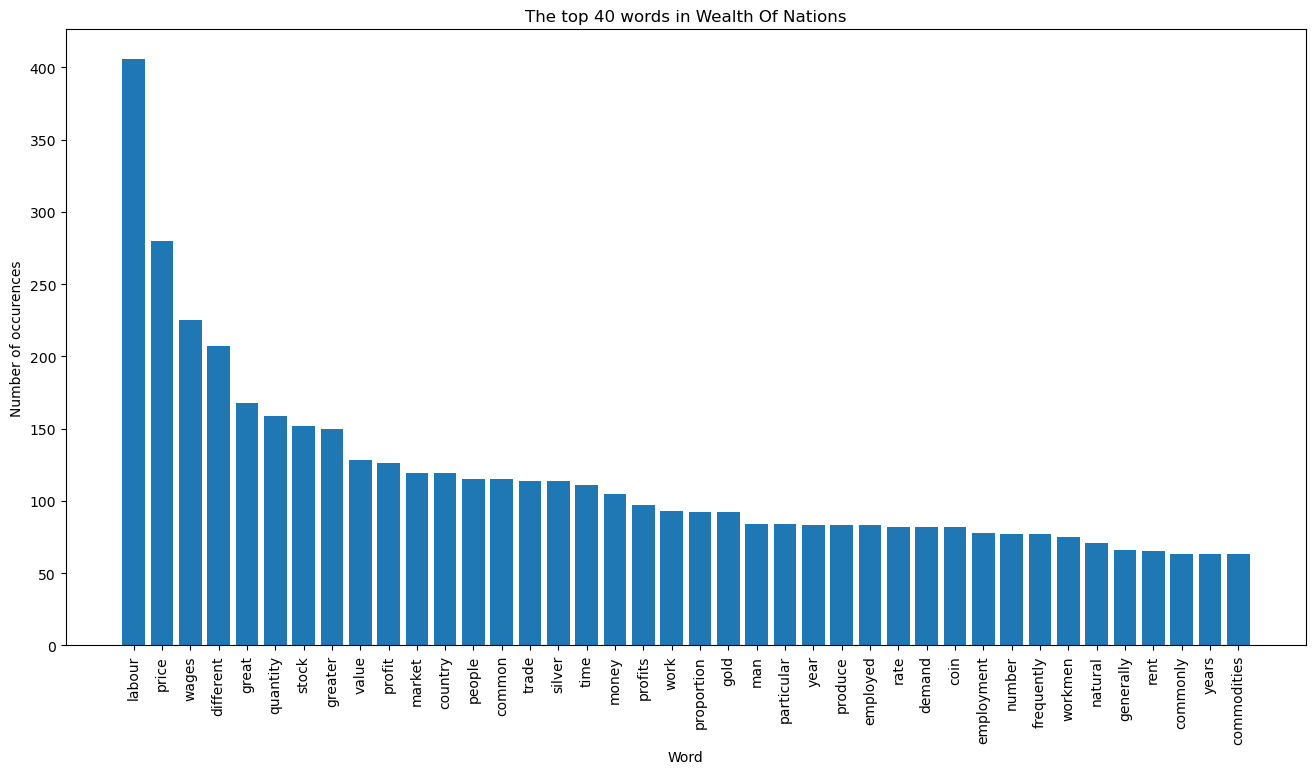

In [13]:
words = []
word_values = []
for i,j in get_top_n_words(df['Sentence2'], 40):
    words.append(i)
    word_values.append(j)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title("The top 40 words in Wealth Of Nations");
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

### Important Words

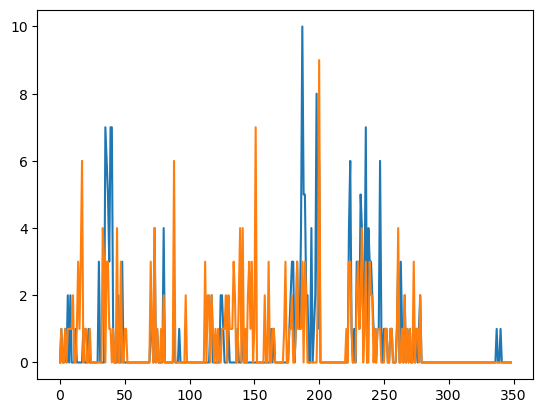

In [57]:
word_x_1 = 'profit'
word_x_2 = 'wages'

important_words_occurences = get_words_paragraphs(paragraphs=text_paragraphs, words=[word_x_1, word_x_2])
word_x_1_occurences = [v for k,v in important_words_occurences.items() if k == word_x_1][0]
word_x_2_occurences = [v for k,v in important_words_occurences.items() if k == word_x_2][0]

bool_word_x_1_occurences = [bool(v) for v in word_x_1_occurences]
bool_word_x_2_occurences = [bool(v) for v in word_x_2_occurences]

plt.plot(word_x_1_occurences)
plt.plot(word_x_2_occurences)

Postive words count in paragraphs that contain both word_x_1 and word_x_2

In [58]:
word_y  = "postive"
list_word_y = []
file_path ="/Users/muhenan/Desktop/Neu_Semester/freshman_first/Classes/INFO_6105_DS/W12L1/positive-words.txt"
with open(file_path, "r") as input:
    pair_lines = input.read().split("\n")
for p in pair_lines:
    list_word_y.append(p.split('\t')[0])

print(list_word_y[0:10])

['abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade']


100%|██████████| 349/349 [00:00<00:00, 645.93it/s]


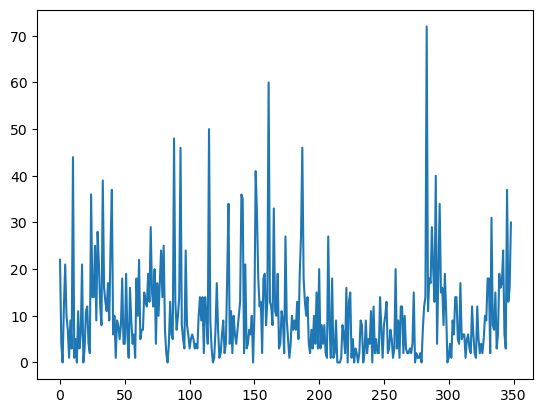

In [59]:
word_y_occurences = get_any_words_paragraphs(text_paragraphs, list_word_y)
plt.plot(word_y_occurences)

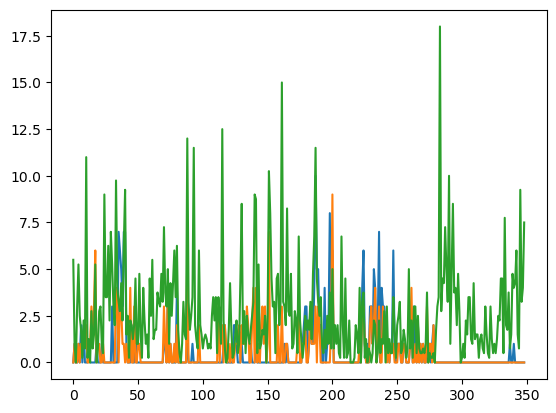

In [60]:
plt.plot(word_x_1_occurences)
plt.plot(word_x_2_occurences)
plt.plot([m / 4 for m in  word_y_occurences])

In [61]:
df_y_occurence_x_occurence = pd.DataFrame(
    list(zip(word_y_occurences, word_x_1_occurences, word_x_2_occurences)), 
    columns =[word_y, word_x_1, word_x_2]
)
df_y_occurence_x_occurence

postive  profit  wages
0         22       0      0
1          4       1      1
2          0       0      0
3         12       0      0
4         21       1      1
..       ...     ...    ...
344        3       0      0
345       37       0      0
346       13       0      0
347       16       0      0
348       30       0      0

[349 rows x 3 columns]

### Negative binomial model

In [62]:
fml = f"{word_y} ~ {word_x_1} + {word_x_2} + {word_x_1}:{word_x_2}" 

with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=fml, data=df_y_occurence_x_occurence, family=pm.glm.families.NegativeBinomial())
    trace = pm.sample(5000, cores=2)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/var/folders/06/vtkypm6s2vggv926_2kl6l8r0000gn/T/ipykernel_46995/839166026.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, profit:wages, wages, profit, Intercept]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 14 seconds.


In [63]:
rvs = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
rvs

['Intercept', 'profit', 'wages', 'profit:wages', 'mu', 'alpha']

/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/var/folders/06/vtkypm6s2vggv926_2kl6l8r0000gn/T/ipykernel_46995/4124140005.py:8: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  ax = pm.traceplot(trcs, var_names=varnames, figsize=(12,nrows*1.4),
/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context

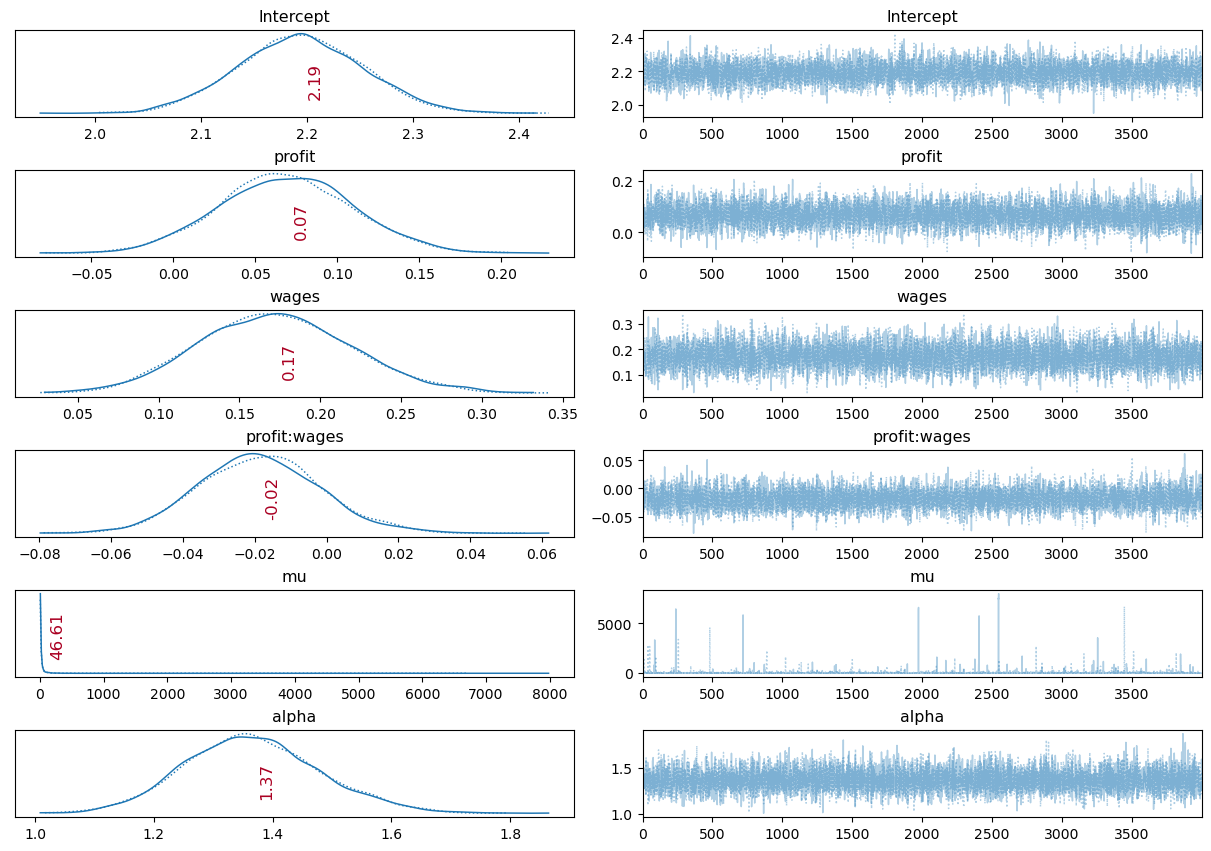

In [64]:
plot_traces(trace[1000:], varnames=rvs);

In [65]:
# Transform coefficients to recover parameter values
np.exp(pm.summary(trace[1000:], var_names=rvs))

/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


mean             sd    hdi_3%       hdi_97%  mcse_mean  \
Intercept     8.971026e+00   1.059715e+00  8.012477  9.964213e+00   1.001001   
profit        1.071436e+00   1.041852e+00  0.993024  1.158354e+00   1.001001   
wages         1.187678e+00   1.048122e+00  1.089806  1.296930e+00   1.001001   
profit:wages  9.811794e-01   1.017145e+00  0.951229  1.014098e+00   1.000000   
mu            1.745949e+20  3.900886e+121  1.007025  7.788675e+45  96.254911   
alpha         3.919641e+00   1.119632e+00  3.202719  4.893951e+00   1.001001   

                mcse_sd  ess_bulk  ess_tail     r_hat  
Intercept      1.001001       inf       inf  2.718282  
profit         1.000000       inf       inf  2.718282  
wages          1.000000       inf       inf  2.718282  
profit:wages   1.000000       inf       inf  2.718282  
mu            27.357754       inf       inf  2.718282  
alpha          1.001001       inf       inf  2.718282

In [66]:
df_y_occurence_x_bool = pd.DataFrame(list(zip(word_y_occurences, 
                                              bool_word_x_1_occurences, 
                                              bool_word_x_2_occurences)), 
                        columns =[word_y, f'{word_x_1}_p', f'{word_x_2}_p'])
df_y_occurence_x_bool

postive  profit_p  wages_p
0         22     False    False
1          4      True     True
2          0     False    False
3         12     False    False
4         21      True     True
..       ...       ...      ...
344        3     False    False
345       37     False    False
346       13     False    False
347       16     False    False
348       30     False    False

[349 rows x 3 columns]

/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


[Text(0, 0, '0'),
 Text(5, 0, '5'),
 Text(10, 0, '10'),
 Text(15, 0, '15'),
 Text(20, 0, '20'),
 Text(25, 0, '25'),
 Text(30, 0, '30'),
 Text(35, 0, '35'),
 Text(40, 0, '40')]

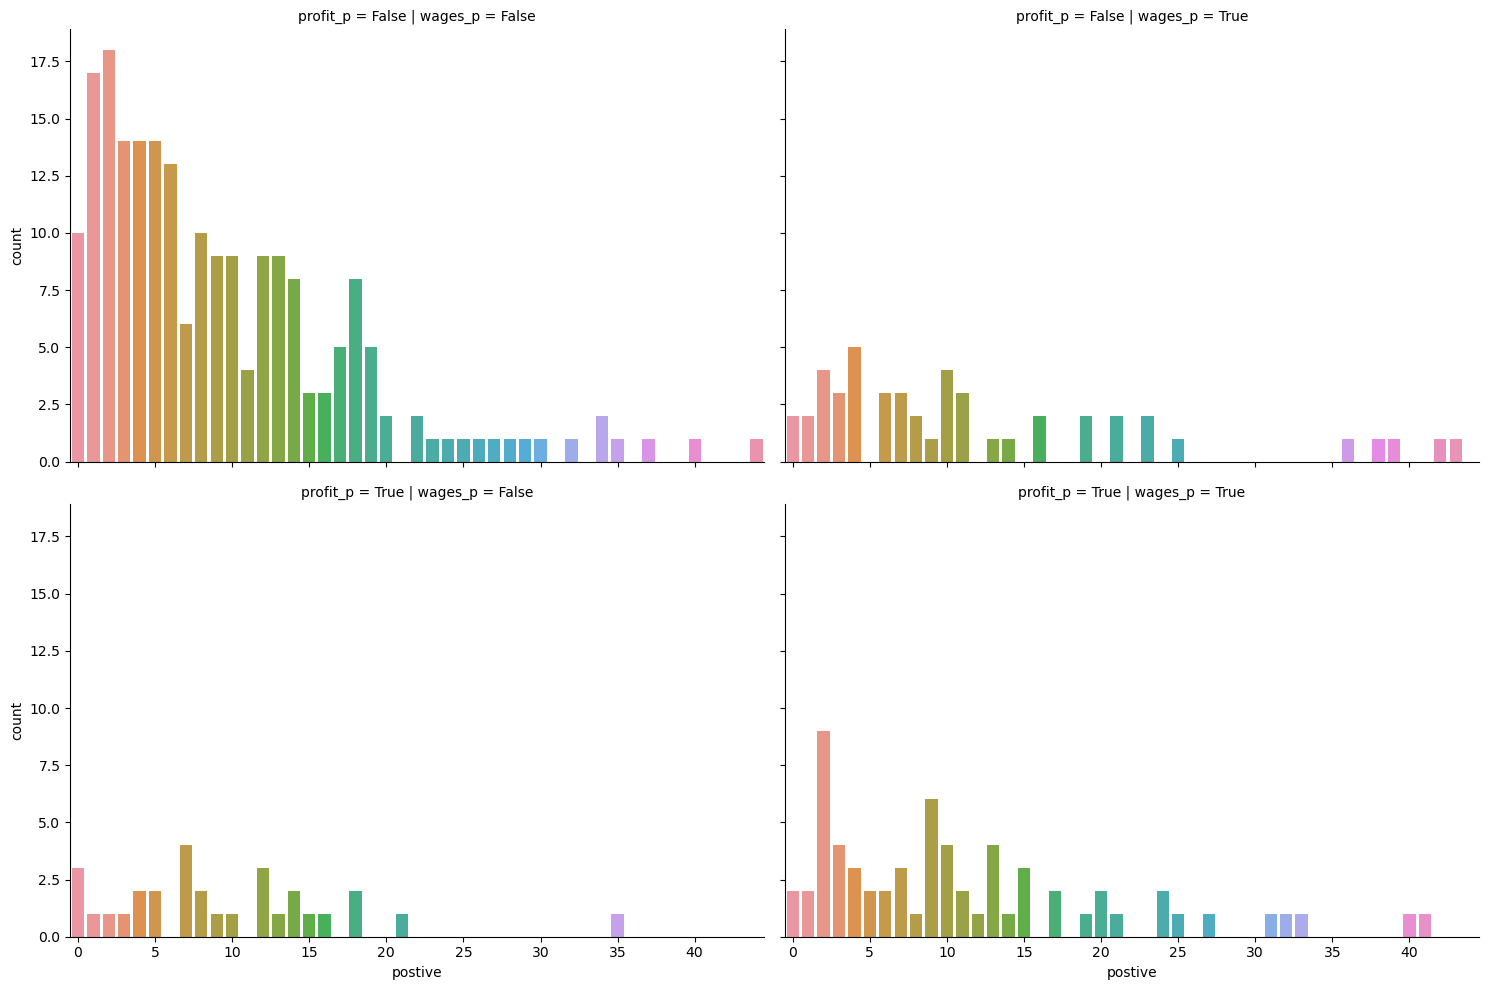

In [67]:
g = sns.factorplot(x=word_y, 
                   row=f'{word_x_1}_p', 
                   col=f'{word_x_2}_p', 
                   data=df_y_occurence_x_bool, 
                   kind='count', aspect=1.5)

# Make x-axis ticklabels less crowded
ax = g.axes[1, 0]
labels = range(len(ax.get_xticklabels(which='both')))
ax.set_xticks(labels[::5])
ax.set_xticklabels(labels[::5])

In [68]:
df_y_occurence_x_bool.groupby([f'{word_x_1}_p', f'{word_x_2}_p'])[word_y].agg(['mean', 'var'])

mean         var
profit_p wages_p                       
False    False     9.666667   91.533981
         True     13.000000  188.085106
True     False     9.633333   60.309195
         True     11.718750  117.062500

In [69]:
fml = f"{word_y} ~ {word_x_1}_p + {word_x_2}_p + {word_x_1}_p:{word_x_2}_p" 

with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=fml, data=df_y_occurence_x_bool, family=pm.glm.families.NegativeBinomial())
    trace = pm.sample(5000, cores=2)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/var/folders/06/vtkypm6s2vggv926_2kl6l8r0000gn/T/ipykernel_46995/779746861.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, profit_p[T.True]:wages_p[T.True], wages_p[T.True], profit_p[T.True], Intercept]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 14 seconds.


['Intercept', 'profit_p[T.True]', 'wages_p[T.True]', 'profit_p[T.True]:wages_p[T.True]', 'mu', 'alpha']


/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/var/folders/06/vtkypm6s2vggv926_2kl6l8r0000gn/T/ipykernel_46995/4124140005.py:8: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  ax = pm.traceplot(trcs, var_names=varnames, figsize=(12,nrows*1.4),
/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context

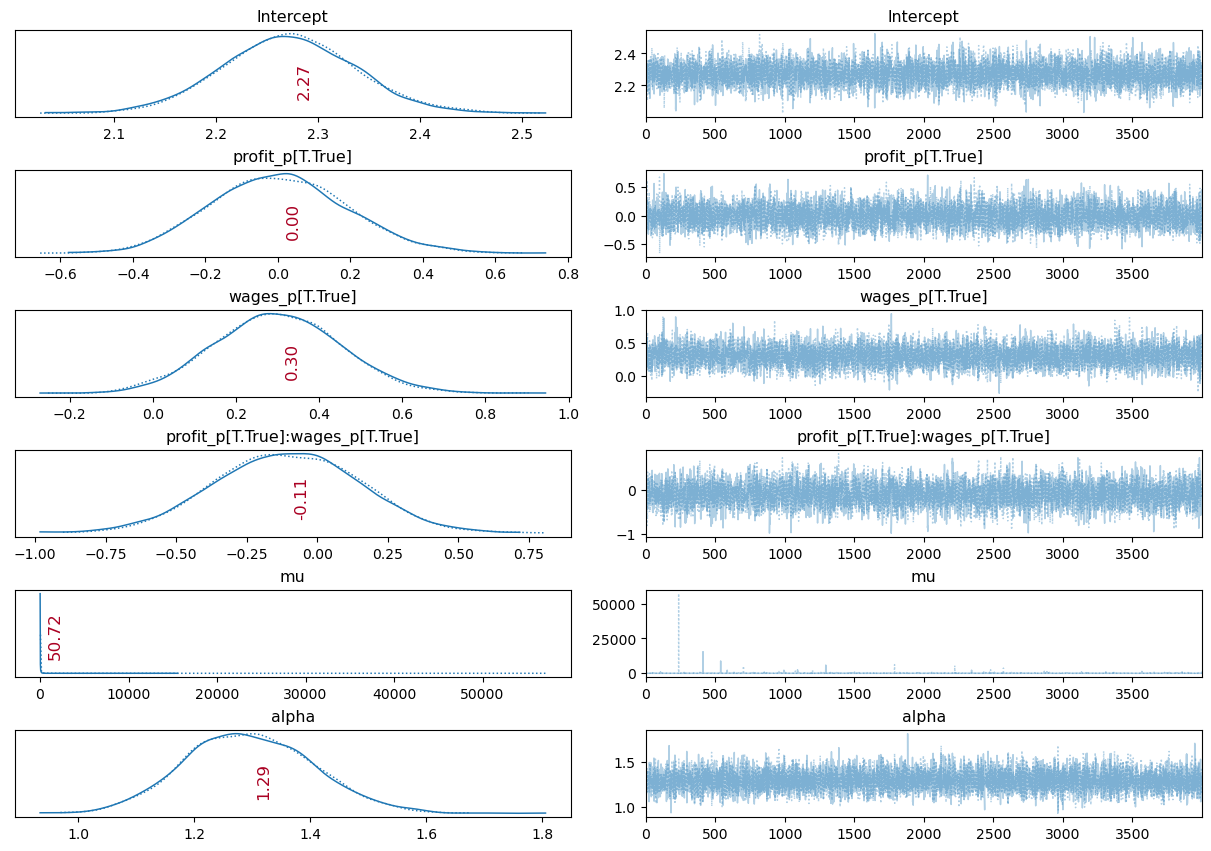

In [70]:
rvs = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
print(rvs)
plot_traces(trace[1000:], varnames=rvs);

In [71]:
np.exp(pm.summary(trace[500:], var_names=rvs)[['mean','hdi_3%','hdi_97%']])

/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean    hdi_3%       hdi_97%
Intercept                         9.689085e+00  8.602045  1.099016e+01
profit_p[T.True]                  1.004008e+00  0.706805  1.411990e+00
wages_p[T.True]                   1.349859e+00  1.019182  1.791405e+00
profit_p[T.True]:wages_p[T.True]  8.985257e-01  0.561019  1.454991e+00
mu                                1.705252e+21  1.002002  3.827017e+46
alpha                             3.647347e+00  2.983210  4.463798e+00

## NetWork Model

In [29]:
#model = SentenceTransformer('stsb-roberta-large') #1,024 dims
#model2 = SentenceTransformer('bert-base-nli-mean-tokens') #768 dims
bmodel = SentenceTransformer('all-MiniLM-L6-v2') #384 dims

transfer text_sentences to vectors through bmodel

In [30]:
bert_embeddings = bmodel.encode(text_sentences)
bert_embeddings.shape

(1809, 384)

In [31]:
#Print the embeddings
for i, (sentence, embedding) in enumerate(zip(text_sentences, bert_embeddings)):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")
    if i == 3: break

Sentence: The whole of the advantages and disadvantages of the different employments of labour and stock must, in the same neighbourhood, be either perfectly equal or continually tending to equality
Embedding: [-4.17577708e-03 -1.65241491e-02 -1.06838346e-02  1.07195778e-02
  6.48879167e-03  4.33927886e-02 -6.01227656e-02 -6.04112670e-02
 -6.23330735e-02 -2.17903499e-02  4.58779484e-02  2.06839591e-02
 -3.83307077e-02  3.94140035e-02  2.55525950e-02 -1.84649378e-02
  2.74618901e-02  2.60435399e-02 -3.16081680e-02 -3.87181789e-02
 -5.97536787e-02 -1.27213284e-01 -7.36500248e-02  4.36115973e-02
 -1.14134643e-02 -2.88449917e-02  2.09798105e-02  7.53075778e-02
  9.01257545e-02 -2.82056499e-02  2.91468184e-02  2.76249368e-02
  9.43058282e-02  2.14799959e-02 -4.02423590e-02 -1.93838961e-03
  3.73307280e-02 -2.56296434e-02  3.65289785e-02 -3.48020270e-02
  6.08896022e-04 -8.73976275e-02 -6.74259439e-02 -5.62097840e-02
 -3.35393623e-02  5.99406771e-02  9.55753550e-02 -3.50853428e-02
 -2.789220

calculate the cosine-similarity of two vectors a and b

In [32]:
import numpy as np
a = bert_embeddings[0]
b = bert_embeddings[1]
cos_sim = (a @ b.T) / (np.linalg.norm(a)*np.linalg.norm(b))
cos_sim

0.54834366

In [33]:
bert_embeddings.shape

(1809, 384)

Calculate the cosine similarity of all the vectors

In [34]:
#M = np.zeros((1933, 1933))
M = np.eye(1933)

for i,a in tqdm(enumerate(bert_embeddings)):
    for j,b in enumerate(bert_embeddings):
        if i != j:
            M[i,j] = (a @ b.T) / (np.linalg.norm(a)*np.linalg.norm(b))

1809it [00:29, 60.81it/s]


In [35]:
similarity_graph = networkx.from_numpy_array(M)
similarity_graph

Use pagerank algorithm to find the importances of all the vectors

In [36]:
scores = networkx.pagerank(similarity_graph)
nx_ranked_sentences = sorted(((score, index) for index, score 
                                            in scores.items()), 
                          reverse=True)
nx_ranked_sentences[:10]

[(0.0008074061145392622, 1365),
 (0.0008069682123076043, 1238),
 (0.0007880468237778783, 1612),
 (0.0007875096345660644, 527),
 (0.0007870633352456242, 1582),
 (0.0007844845280190495, 1608),
 (0.0007837330964849844, 708),
 (0.0007804804950570074, 884),
 (0.0007765144581715013, 1583),
 (0.0007736861222717369, 592)]

Get the most important sentence

In [37]:
text_sentences[1365]

'The wages of the labour and the profits of the stock employed in bringing such commodities to market, on the contrary, are seldom out of their natural proportion to those of the other employments of labour and stock in their neighbourhood'

Let see the most important ten sentences

In [38]:
for i in range(10):
    print(text_sentences[nx_ranked_sentences[i][1]])
    print('----------')

The wages of the labour and the profits of the stock employed in bringing such commodities to market, on the contrary, are seldom out of their natural proportion to those of the other employments of labour and stock in their neighbourhood
----------

In the most improved societies, however, there are always a few commodities of which the price resolves itself into two parts only, the wages of labour, and the profits of stock; and a still smaller number, in which it consists altogether in the wages of labour
----------
Every other commodity, however, will at any particular time purchase a greater or smaller quantity of labour in proportion to the quantity of subsistence which it can purchase at that time
----------

It frequently happens that while high wages are given to the workmen in one manufacture, those in another are obliged to content themselves with bare subsistence
----------

But though equal quantities of labour are always of equal value to the labourer, yet to the person wh

## Semantic Model (Clustering)

In this part, we use K-Medoids algorithm to cluster sentences into 10 clusters.

In [39]:
digits = load_digits()
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

In [40]:
digits.data.shape

(1797, 64)

In [41]:
num_digits = len(np.unique(digits.target))
num_digits

10

In [42]:
np.std(bert_embeddings[0])

0.051025774

In [43]:
bert_embeddings_std = scale(bert_embeddings)

/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Use PCA algorithm to do dimensionality reduction.

In [44]:
bert_embeddings_red = PCA(n_components=2).fit_transform(bert_embeddings_std)

Plot the decision boundaries for each cluster. Assign a different color to each for differentiation.

In [45]:
h = 0.02 #step size of the mesh 
#Minimum and maximum x-coordinates
xmin, xmax = bert_embeddings_red[:, 0].min() - 1, bert_embeddings_red[:, 0].max() + 1
#Minimum and maximum y-coordinates
ymin, ymax = bert_embeddings_red[:, 1].min() - 1, bert_embeddings_red[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))

Define an array of K-Medoids variants to be used. We have used three different distance metrics (Manhattan distance, Euclidean distance and Cosine dissimilarity/distance) for computing the distance of each data point from every other data point while selecting the medoid.

In [46]:
models = [
     (
         KMedoids(metric="manhattan", n_clusters=num_digits, 
         init="heuristic", max_iter=2),"Manhattan metric",
     ),
     (
         KMedoids(metric="euclidean", n_clusters=num_digits,  
         init="heuristic", max_iter=2),"Euclidean metric",
     ),
     (KMedoids(metric="cosine", n_clusters=num_digits, init="heuristic", 
      max_iter=2), "Cosine metric", ),
 ]
models

[(KMedoids(max_iter=2, metric='manhattan', n_clusters=10), 'Manhattan metric'),
 (KMedoids(max_iter=2, n_clusters=10), 'Euclidean metric'),
 (KMedoids(max_iter=2, metric='cosine', n_clusters=10), 'Cosine metric')]

In [47]:
#number of rows = integer(ceiling(number of model variants/2))
num_rows = int(np.ceil(len(models) / 2.0))
#number of columns
num_cols = 2 

Fit each of the model variants to the data and plot the resultant clustering

In [48]:
#Clear the current figure first (if any)
plt.clf()

#Initialize dimensions of the plot
plt.figure(figsize=(15,10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Do clustering and visualization

/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


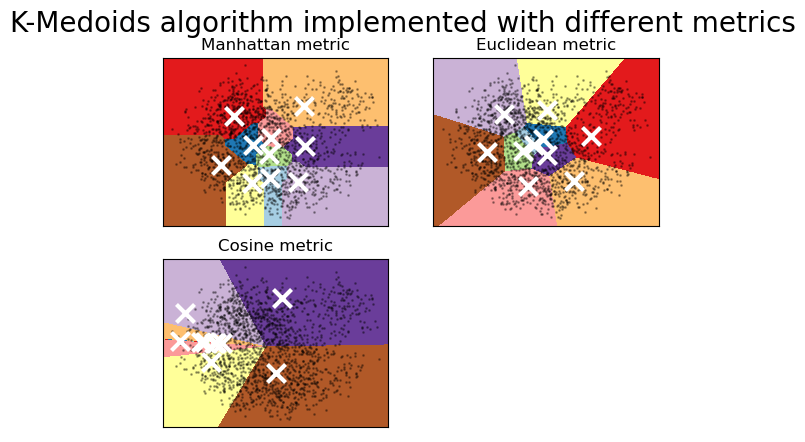

In [49]:
for i, (model, description) in enumerate(models):
    # Fit each point in the mesh to the model
    model.fit(bert_embeddings_red)
    
    #Predict the labels for points in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result  into a color plot
    Z = Z.reshape(xx.shape)
   
    #Subplot for the ith model variant
    plt.subplot(num_cols, num_rows, i + 1)
   
    #Display the subplot
    plt.imshow(
         Z,    #data to be plotted
         interpolation="nearest",
        #bounding box coordinates (left,right,bottom,top)
         extent=(xx.min(), xx.max(), yy.min(), yy.max()),
         cmap=plt.cm.Paired,  #colormap
         aspect="auto", #aspect ratio of the axes
         origin="lower",  #set origin as lower left corner of the axes
    )
    plt.plot(
         bert_embeddings_red[:, 0], bert_embeddings_red[:, 1], "k.", markersize=2, alpha=0.3
    )
        
    # Plot the centroids as white cross marks
    centroids = model.cluster_centers_
    plt.scatter(
         centroids[:, 0],
         centroids[:, 1],
         marker="x",
         s=169,  #marker’s size (points^2)
         linewidths=3, #width of boundary lines
         color="w",  #white color for centroids markings
         zorder=10,  #drawing order of axes
    )
    
    #describing text of the tuple will be title of the subplot
    plt.title(description)  
    plt.xlim(xmin, xmax)  #limits of x-coordinates
    plt.ylim(ymin, ymax)  #limits of y-coordinates
    plt.xticks(())   
    plt.yticks(())
    
#Upper title of the whole plot
plt.suptitle(
    #Text to be displayed
    "K-Medoids algorithm implemented with different metrics\n\n",
    fontsize=20,  #size of the fonts
)
plt.show()

In [50]:
centroids

array([[-5.5976925 ,  0.4571037 ],
       [-4.684973  ,  0.41303045],
       [-5.313703  ,  0.4371641 ],
       [-9.219562  ,  0.7373458 ],
       [-6.9588823 ,  0.58824396],
       [-6.465415  ,  0.59171563],
       [-8.610203  ,  4.308852  ],
       [ 1.7881608 ,  6.261898  ],
       [-5.8485518 , -2.0425165 ],
       [ 1.132864  , -3.4595    ]], dtype=float32)

In [51]:
centroids = []
for i, (model, description) in enumerate(models):
    model.fit(bert_embeddings_std)
    centroids.append(model.cluster_centers_)

/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [52]:
centroid_indeces = []

for i in range(10):
    c = centroids[2][i]
    for j in range(bert_embeddings_std.shape[0]):
        if np.allclose(c, bert_embeddings_std[j]):
            centroid_indeces.append(j)
            break

Let's see the topic sentences of the 10 clusters.

In [53]:
centroid_indeces

[865, 1279, 978, 1657, 1612, 69, 1582, 25, 706, 1377]

In [54]:
for i in centroid_indeces:
    print(i, ' -------')
    print(text_sentences[i])
    print('---------')

865  -------
Workmen, on the contrary, when they are liberally paid by the piece, are very apt to overwork themselves, and to ruin their health and constitution in a few years
---------
1279  -------

As in a civilised country there are but few commodities of which the exchangeable value arises from labour only, rent and profit contributing largely to that of the far greater part of them, so the annual produce of its labour will always be sufficient to purchase or command a much greater quantity of labour than what employed in raising, preparing, and bringing that produce to market
---------
978  -------
The great stocks employed in every branch of trade, and the number of rich competitors, generally reduce the rate of profit in the former below what it is in the latter But the wages of labour are generally higher in a great town than in a country village
---------
1657  -------
There were silver coins in England in the time of the Saxons; but there was little gold coined till the time

# Just For Fun!

![](./images/dua.jpeg)


### Library

In [11]:

import pandas as pd
from textblob import TextBlob
import re

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/XuLiu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Utility Function

In [3]:
def eda(sentences):
    processed_sentences = []

    for s in sentences:
        # Remove all the special characters
        processed_sentence = re.sub(r'\W', ' ', str(s))

        # remove all single characters
        processed_sentence= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_sentence)

        # Remove single characters from the start
        processed_sentence = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_sentence) 

        # Substituting multiple spaces with single space
        processed_sentence = re.sub(r'\s+', ' ', processed_sentence, flags=re.I)

        # Removing prefixed 'b'
        processed_sentence = re.sub(r'^b\s+', '', processed_sentence)

        # Converting to Lowercase
        processed_sentence = processed_sentence.lower()

        processed_sentences.append(processed_sentence)
        
    return processed_sentences

### dataset

Let's get Dua Lipa's lyrics

In [13]:
from datasets import load_dataset

df_dualipa = load_dataset("huggingartists/dua-lipa")

Found cached dataset dua-lipa (/Users/XuLiu/.cache/huggingface/datasets/huggingartists___dua-lipa/default/1.0.0/ebf0799aab5ed80bd11eb847f5f8ec2ca801478aa1f41838ada6d5b7d5545042)


  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
list_lyric = df_dualipa['train']['text']
list_lyric[0]

'One, one, one, one, one\nTalkin in my sleep at night, makin myself crazy\nWrote it down and read it out, hopin it would save me\nMy love, he makes me feel like nobody else, nobody else\nBut my love, he doesnt love me, so I tell myself, I tell myself\nOne: Dont pick up the phone\nYou know hes only callin cause hes drunk and alone\nTwo: Dont let him in\nYoull have to kick him out again\nThree: Dont be his friend\nYou know youre gonna wake up in his bed in the morning\nAnd if youre under him, you aint gettin over him\nI got new rules, I count em\nI got new rules, I count em\nI gotta tell them to myself\nI got new rules, I count em\nI gotta tell them to myself\nI keep pushin forwards, but he keeps pullin me backwards\nNow Im standin back from it, I finally see the pattern\nBut my love, he doesnt love me, so I tell myself, I tell myself\nI do, I do, I do\nOne: Dont pick up the phone\nYou know hes only callin cause hes drunk and alone\nTwo: Dont let him in\nYoull have to kick him out again\

In [20]:
list_lyric_processed = eda(list_lyric)
all_lyric_processed = "|".join(list_lyric_processed)

sentence = all_lyric_processed

sentence


'one one one one one talkin in my sleep at night makin myself crazy wrote it down and read it out hopin it would save me my love he makes me feel like nobody else nobody else but my love he doesnt love me so tell myself tell myself one dont pick up the phone you know hes only callin cause hes drunk and alone two dont let him in youll have to kick him out again three dont be his friend you know youre gonna wake up in his bed in the morning and if youre under him you aint gettin over him got new rules count em got new rules count em gotta tell them to myself got new rules count em gotta tell them to myself keep pushin forwards but he keeps pullin me backwards now im standin back from it finally see the pattern but my love he doesnt love me so tell myself tell myself do do do one dont pick up the phone you know hes only callin cause hes drunk and alone two dont let him in youll have to kick him out again three dont be his friend you know youre gonna wake up in his bed in the morning and i

### Sentiment analysis

What are Dua Lipa's feelings about the world? 🤔

In [21]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(sentence)

{'neg': 0.133, 'neu': 0.698, 'pos': 0.169, 'compound': 1.0}

In [22]:
TextBlob(sentence).sentiment

Sentiment(polarity=0.07377976367725096, subjectivity=0.5574185915545867)

Looks like she thinks this world in a postive way! ❤️ 

Let's do the wordclould of her lyrics🎙️.

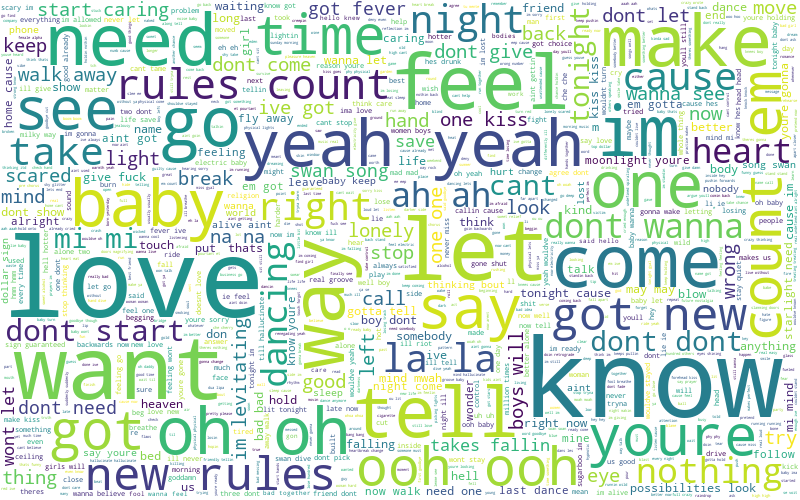

In [23]:
from wordcloud import WordCloud

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=500, 
                      max_font_size=110, 
                      background_color="white", max_words=3000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(all_lyric_processed)

# Visualize the word cloud
wordcloud.to_image()

Oh Oh Oh Oh Oh.... yeah yeah yeah...! I know I feel love!


Her lyrics convey love, even for those who only have a basic understanding of English！😉